In [1]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, average_precision_score
import insightface
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time

In [2]:
# -----------------------
# 1 Carregar dataset LFW completo
# -----------------------
print("Carregando dataset LFW...")
lfw = fetch_lfw_people(color=True, resize=0.5, min_faces_per_person=5)
images = lfw.images
labels = lfw.target
names = lfw.target_names
print(f"Total de imagens: {len(images)}")
print(f"Pessoas distintas: {len(set(labels))}")

📥 Carregando dataset LFW...
Total de imagens: 5985
Pessoas distintas: 423


In [3]:

# -----------------------
# 2 Carregar modelo InsightFace
# -----------------------
print("Carregando modelo InsightFace...")
app = insightface.app.FaceAnalysis(providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(224, 224))

⚡ Carregando modelo InsightFace...
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/luan/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/luan/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/luan/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/luan/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/luan/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3,

In [4]:

# -----------------------
# 3 Extrair embeddings
# -----------------------
print("Extraindo embeddings...")
start_emb = time.time()
embeddings = []
new_labels = []

for img, label in zip(images, labels):
    img_uint8 = (img * 255).astype(np.uint8)
    faces = app.get(img_uint8)
    if faces:
        embeddings.append(faces[0].embedding)
        new_labels.append(label)

embeddings = np.array(embeddings)
labels = np.array(new_labels)
print(f"Embeddings extraídos: {embeddings.shape}")
print(f"Tempo de extração de embeddings: {time.time() - start_emb:.2f} s")

if len(embeddings) == 0:
    raise RuntimeError("Nenhum embedding foi gerado.")


🔎 Extraindo embeddings...


/home/luan/.pyenv/versions/3.10.12/envs/teste_modelo/lib/python3.10/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


✅ Embeddings extraídos: (5984, 512)
⏱️ Tempo de extração de embeddings: 530.94 s


In [5]:

# -----------------------
# 4 Verificação 1:1 (pares)
# -----------------------
print("Gerando pares 1:1...")
start_pairs = time.time()
all_pairs = list(combinations(range(len(embeddings)), 2))
n_pairs = min(50000, len(all_pairs))  # limitar para 50k pares aleatórios
pairs_indices = np.array(all_pairs)[np.random.choice(len(all_pairs), n_pairs, replace=False)]

pairs_scores = []
pairs_labels = []

for i, j in pairs_indices:
    emb1 = embeddings[i]
    emb2 = embeddings[j]
    sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))  # similaridade cosseno
    pairs_scores.append(sim)
    pairs_labels.append(1 if labels[i] == labels[j] else 0)

pairs_scores = np.array(pairs_scores)
pairs_labels = np.array(pairs_labels)
print(f"Tempo de cálculo de pares 1:1: {time.time() - start_pairs:.2f} s")


🔗 Gerando pares 1:1...
⏱️ Tempo de cálculo de pares 1:1: 5.32 s


In [6]:

# -----------------------
# 5 Métricas clássicas
# -----------------------
# ROC e EER
fpr, tpr, thresholds = roc_curve(pairs_labels, pairs_scores)
roc_auc = auc(fpr, tpr)
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
EER = fpr[np.nanargmin(np.abs(fnr - fpr))]

# Convertendo similaridade para binário usando limiar EER
pred_labels = (pairs_scores >= eer_threshold).astype(int)

# Métricas adicionais
accuracy = accuracy_score(pairs_labels, pred_labels)
precision = precision_score(pairs_labels, pred_labels)
recall = recall_score(pairs_labels, pred_labels)
f1 = f1_score(pairs_labels, pred_labels)
kappa = cohen_kappa_score(pairs_labels, pred_labels)
mAP = average_precision_score(pairs_labels, pairs_scores)  # usa scores contínuos

print("Métricas 1:1")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Revocação: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"mAP: {mAP:.4f}")
print(f"Kappa de Cohen: {kappa:.4f}")
print(f"EER: {EER:.4f} (threshold={eer_threshold:.4f})")


✅ Métricas 1:1
Acurácia: 1.0000
Precisão: 0.9984
Revocação: 1.0000
F1-Score: 0.9992
AUC-ROC: 1.0000
mAP: 1.0000
Kappa de Cohen: 0.9992
EER: 0.0000 (threshold=0.3520)


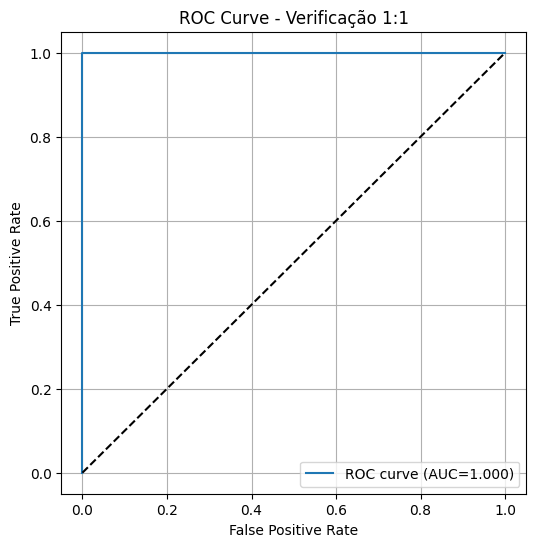

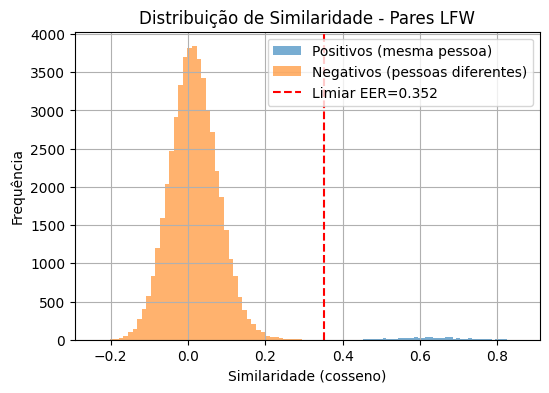

In [7]:

# -----------------------
# 6 Visualizações
# -----------------------
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Verificação 1:1")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(pairs_scores[pairs_labels==1], bins=50, alpha=0.6, label="Positivos (mesma pessoa)")
plt.hist(pairs_scores[pairs_labels==0], bins=50, alpha=0.6, label="Negativos (pessoas diferentes)")
plt.axvline(eer_threshold, color="red", linestyle="--", label=f"Limiar EER={eer_threshold:.3f}")
plt.xlabel("Similaridade (cosseno)")
plt.ylabel("Frequência")
plt.title("Distribuição de Similaridade - Pares LFW")
plt.legend()
plt.grid()
plt.show()


✅ Métricas 1:1
Acurácia: 1.0000
Precisão: 1.0000
Revocação: 1.0000
F1-Score: 1.0000
AUC-ROC: 1.0000
mAP: 1.0000
Kappa de Cohen: 1.0000
EER: 0.0000 (threshold=0.3524)

🎯 Top-k Accuracy:
Top-1 Accuracy: 99.92%
Top-3 Accuracy: 99.93%

Matriz de Confusão:
[[9856    0]
 [   0  144]]


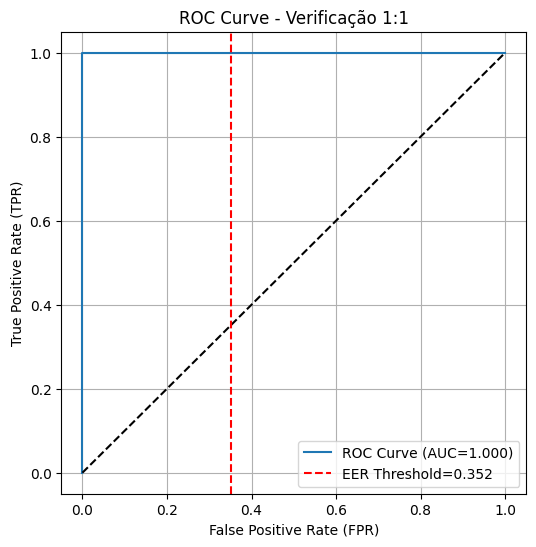

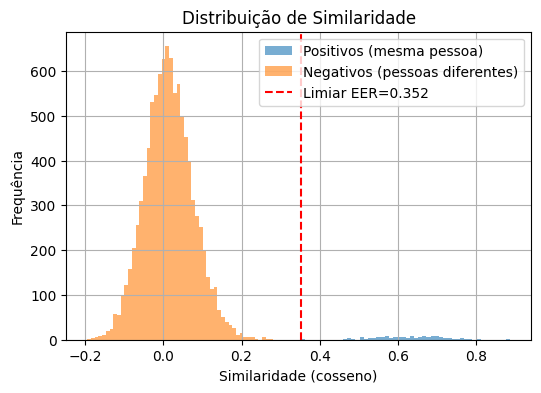

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, cohen_kappa_score
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

# -----------------------
# Gerar pares 1:1
# -----------------------
pairs = list(combinations(range(len(embeddings)), 2))
pairs = np.random.choice(len(pairs), min(10000, len(pairs)), replace=False)
pairs_indices = np.array(list(combinations(range(len(embeddings)), 2)))[pairs]

pairs_scores = []
pairs_labels = []

for i, j in pairs_indices:
    sim = np.dot(embeddings[i], embeddings[j]) / (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))
    pairs_scores.append(sim)
    pairs_labels.append(1 if labels[i] == labels[j] else 0)

pairs_scores = np.array(pairs_scores)
pairs_labels = np.array(pairs_labels)

# -----------------------
# ROC Curve, AUC e EER
# -----------------------
fpr, tpr, thresholds = roc_curve(pairs_labels, pairs_scores)
roc_auc = auc(fpr, tpr)
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
EER = fpr[np.nanargmin(np.abs(fnr - fpr))]

# -----------------------
# Classificação binária usando limiar EER
# -----------------------
pred_labels = (pairs_scores >= eer_threshold).astype(int)

# -----------------------
# Métricas principais
# -----------------------
accuracy = accuracy_score(pairs_labels, pred_labels)
precision = precision_score(pairs_labels, pred_labels)
recall = recall_score(pairs_labels, pred_labels)
f1 = f1_score(pairs_labels, pred_labels)
kappa = cohen_kappa_score(pairs_labels, pred_labels)

# -----------------------
# mAP (Mean Average Precision)
# -----------------------
# Para 1:1, mAP pode ser aproximado pelo valor médio de precision sobre todos os thresholds
sorted_indices = np.argsort(-pairs_scores)
sorted_labels = pairs_labels[sorted_indices]
cumsum_true = np.cumsum(sorted_labels)
precision_at_k = cumsum_true / (np.arange(len(sorted_labels)) + 1)
mAP = np.mean(precision_at_k[sorted_labels == 1])  # média apenas sobre positivos

# -----------------------
# Top-k Accuracy (1:N)
# -----------------------
sim_matrix = cosine_similarity(embeddings)
np.fill_diagonal(sim_matrix, -np.inf)

top1 = 0
top3 = 0
for i in range(len(embeddings)):
    neighbors = np.argsort(-sim_matrix[i])
    if labels[i] == labels[neighbors[0]]:
        top1 += 1
    if labels[i] in labels[neighbors[:3]]:
        top3 += 1

top1_acc = top1 / len(embeddings)
top3_acc = top3 / len(embeddings)

# -----------------------
# Resultados
# -----------------------
print("Métricas 1:1")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Revocação: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"mAP: {mAP:.4f}")
print(f"Kappa de Cohen: {kappa:.4f}")
print(f"EER: {EER:.4f} (threshold={eer_threshold:.4f})")
print("\nTop-k Accuracy:")
print(f"Top-1 Accuracy: {top1_acc*100:.2f}%")
print(f"Top-3 Accuracy: {top3_acc*100:.2f}%")
print("\nMatriz de Confusão:")
print(confusion_matrix(pairs_labels, pred_labels))

# -----------------------
# Visualizações
# -----------------------
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.axvline(x=eer_threshold, color='red', linestyle='--', label=f"EER Threshold={eer_threshold:.3f}")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - Verificação 1:1")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(pairs_scores[pairs_labels==1], bins=50, alpha=0.6, label="Positivos (mesma pessoa)")
plt.hist(pairs_scores[pairs_labels==0], bins=50, alpha=0.6, label="Negativos (pessoas diferentes)")
plt.axvline(eer_threshold, color="red", linestyle="--", label=f"Limiar EER={eer_threshold:.3f}")
plt.xlabel("Similaridade (cosseno)")
plt.ylabel("Frequência")
plt.title("Distribuição de Similaridade")
plt.legend()
plt.grid()
plt.show()
